# DSCI 417 - Homework 07
**Malcolm Nichols**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


spark = SparkSession.builder.getOrCreate()

## Problem 1: Decision Tree Classification (3/5)

<pre>
+----+----+----+----+----+-----------+
|  x1|  x2|  x3|  x4|  x5| prediction|  Leaf Node
+----+----+----+----+----+-----------+  ---------
| 3.7| 5.6| 3.6| 1.0| 1.0|        1.0 (0.0)|          4 (3)
| 8.2| 4.2| 2.1| 2.0| 0.0|        0.0|          7
| 5.4| 3.9| 4.9| 2.0| 1.0|        2.0 (1.0)|          5 (6)
| 2.8| 6.1| 8.1| 0.0| 0.0|        2.0|          2
+----+----+----+----+----+-----------+
</pre>

## Problem 2: Random Forest Classification

Tree Model 1 Prediction: 0.0  
Tree Model 2 Prediction: 0.0  
Tree Model 3 Prediction: 1.0  
Random Forest Prediction: 0.0

## Problem 3: Load and Process Stroke Data

In [0]:
my_schema =('gender STRING, age DOUBLE, hypertension INTEGER, heart_disease INTEGER, ever_married STRING,'
            'work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE,'
            'smoking_status STRING, stroke INTEGER')

stroke_df = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema(my_schema)
    .csv('/FileStore/tables/stroke_data.csv')
)

stroke_df.printSchema()

root
-- gender: string (nullable = true)
-- age: double (nullable = true)
-- hypertension: integer (nullable = true)
-- heart_disease: integer (nullable = true)
-- ever_married: string (nullable = true)
-- work_type: string (nullable = true)
-- residence_type: string (nullable = true)
-- avg_glucose_level: double (nullable = true)
-- bmi: double (nullable = true)
-- smoking_status: string (nullable = true)
-- stroke: integer (nullable = true)

In [0]:
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = [c for c in stroke_df.columns[:-1] if c not in num_features]

ix_features = [c + '_ix' for c in cat_features]

feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
assembler = VectorAssembler(inputCols=num_features + ix_features, outputCol='features')

In [0]:
preprocessor = Pipeline(stages=[feature_indexer, assembler]).fit(stroke_df)
train = preprocessor.transform(stroke_df)
train.persist()

train.select('features', 'stroke').show(10, truncate=False)

+----------------------------------------------+------+
features |stroke|
+----------------------------------------------+------+
(10,[0,1,2,6],[13.0,77.63,31.7,1.0]) |0 |
[10.0,84.02,18.7,1.0,0.0,0.0,1.0,3.0,1.0,0.0] |0 |
[82.0,88.6,32.5,0.0,0.0,1.0,0.0,1.0,1.0,1.0] |0 |
[3.0,57.33,16.8,0.0,0.0,0.0,1.0,3.0,0.0,1.0] |0 |
[65.0,220.52,37.2,0.0,0.0,0.0,0.0,1.0,1.0,3.0]|0 |
(10,[0,1,2,7,8],[65.0,100.65,31.0,1.0,1.0]) |1 |
[65.0,56.64,28.4,1.0,0.0,0.0,0.0,0.0,1.0,2.0] |1 |
(10,[0,1,2,8],[28.0,64.64,22.1,1.0]) |0 |
(10,[0,1,2,7,9],[80.0,84.86,29.3,2.0,1.0]) |0 |
(10,[0,1,2,3,9],[78.0,60.22,29.7,1.0,2.0]) |0 |
+----------------------------------------------+------+
only showing top 10 rows

## Problem 4: Hyperparameter Tuning for Decision Trees

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='stroke', metricName='accuracy')

dtree = DecisionTreeClassifier(featuresCol='features', labelCol='stroke', seed=1)

param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, range(2,18,2) )
              .addGrid(dtree.minInstancesPerNode, [4, 8, 16, 32])
             ).build()

cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, numFolds=5, 
                    evaluator=accuracy_eval, seed=1)

cv_model = cv.fit(train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
model = cv_model.bestModel
opt_maxDepth = model.getMaxDepth()
opt_minInstancesPerNode = model.getMinInstancesPerNode()

print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

Max CV Score: 0.7895
Optimal Depth: 6
Optimal MinInst: 16

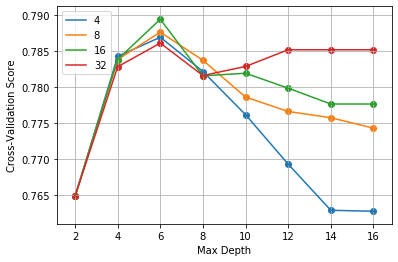

In [0]:
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list, columns=['maxDepth', 'minInst', 'acc'])

for mi in cv_summary.minInst.unique():
    sel = cv_summary.minInst == mi
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel]) 

plt.legend()
plt.grid()
plt.xticks(range(2,18,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')
plt.show()

## Problem 5: Structure of Final Model

In [0]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1f4adeb8b4a4, depth=6, numNodes=53, numClasses=2, numFeatures=10
 If (feature 0 <= 56.5)
 If (feature 5 in {1.0})
 If (feature 9 in {3.0})
 Predict: 0.0
 Else (feature 9 not in {3.0})
 If (feature 4 in {1.0})
 Predict: 1.0
 Else (feature 4 not in {1.0})
 If (feature 2 <= 27.15)
 Predict: 1.0
 Else (feature 2 > 27.15)
 If (feature 3 in {1.0})
 Predict: 0.0
 Else (feature 3 not in {1.0})
 Predict: 1.0
 Else (feature 5 not in {1.0})
 If (feature 0 <= 43.5)
 If (feature 4 in {1.0})
 If (feature 2 <= 28.15)
 Predict: 1.0
 Else (feature 2 > 28.15)
 Predict: 0.0
 Else (feature 4 not in {1.0})
 Predict: 0.0
 Else (feature 0 > 43.5)
 If (feature 1 <= 156.44)
 If (feature 4 in {1.0})
 If (feature 9 in {0.0,2.0,3.0})
 Predict: 0.0
 Else (feature 9 not in {0.0,2.0,3.0})
 Predict: 1.0
 Else (feature 4 not in {1.0})
 Predict: 0.0
 Else (feature 1 > 156.44)
 If (feature 1 <= 236.815)
 Predict: 0.0
 Else (feature 1 > 236.815)
 Predict: 1.0
 Else (feature 0 > 56.5)
 If (feature 0 <= 81.5)
 If (feature 1 <= 118.485)
 If (feature 5 in {1.0})
 If (feature 0 <= 77.5)
 Predict: 1.0
 Else (feature 0 > 77.5)
 If (feature 1 <= 79.625)
 Predict: 1.0
 Else (feature 1 > 79.625)
 Predict: 0.0
 Else (feature 5 not in {1.0})
 If (feature 4 in {1.0})
 If (feature 2 <= 26.05)
 Predict: 1.0
 Else (feature 2 > 26.05)
 Predict: 0.0
 Else (feature 4 not in {1.0})
 Predict: 0.0
 Else (feature 1 > 118.485)
 If (feature 1 <= 236.815)
 If (feature 0 <= 62.5)
 If (feature 3 in {1.0})
 Predict: 0.0
 Else (feature 3 not in {1.0})
 Predict: 1.0
 Else (feature 0 > 62.5)
 If (feature 0 <= 77.5)
 Predict: 1.0
 Else (feature 0 > 77.5)
 Predict: 0.0
 Else (feature 1 > 236.815)
 If (feature 2 <= 29.35)
 If (feature 2 <= 26.05)
 Predict: 1.0
 Else (feature 2 > 26.05)
 Predict: 0.0
 Else (feature 2 > 29.35)
 Predict: 1.0
 Else (feature 0 > 81.5)
 Predict: 1.0

In [0]:
features = num_features + cat_features

print(features)

['age', 'avg_glucose_level', 'bmi', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

First Feature Used in Tree: Age  
Features Unused in Tree: ever_married, work_type, residence_type

In [0]:
pd.DataFrame({
    'feature':features,
    'importance':model.featureImportances
})

Out[10]:

,feature,importance
0,age,0.780537
1,avg_glucose_level,0.064422
2,bmi,0.022221
3,gender,0.004708
4,hypertension,0.030844
5,heart_disease,0.088194
6,ever_married,0.000000
7,work_type,0.000000
8,residence_type,0.000000
9,smoking_status,0.009074


## Problem 6: Applying the Model to New Data

In [0]:
new_data = spark.createDataFrame(
    data = [['Female', 42.0, 1, 0, 'No',  'Private',       'Urban', 181.1, 26.8, 'smokes'],
            ['Female', 64.0, 1, 1, 'Yes', 'Self-employed', 'Rural', 171.5, 32.5, 'formerly smoked'],
            ['Male',   37.0, 0, 0, 'Yes', 'Private',       'Rural',  79.2, 18.4, 'Unknown'],
            ['Male',   72.0, 0, 1, 'No',  'Govt_job',      'Urban', 125.7, 19.4, 'never smoked']],
    schema = (
        'gender STRING, age DOUBLE, hypertension INT, heart_disease INT, ever_married STRING, work_type STRING,'
        'residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING'
    )
)

new_data.show()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
gender| age|hypertension|heart_disease|ever_married| work_type|residence_type|avg_glucose_level| bmi| smoking_status|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
Female|42.0| 1| 0| No| Private| Urban| 181.1|26.8| smokes|
Female|64.0| 1| 1| Yes|Self-employed| Rural| 171.5|32.5|formerly smoked|
 Male|37.0| 0| 0| Yes| Private| Rural| 79.2|18.4| Unknown|
 Male|72.0| 0| 1| No| Govt_job| Urban| 125.7|19.4| never smoked|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+

In [0]:
new_pre_pred = preprocessor.transform(new_data)
new_pred = model.transform(new_pre_pred)
new_pred.select('probability', 'prediction').show(truncate=False)

+-----------------------------------------+----------+
probability |prediction|
+-----------------------------------------+----------+
[0.3125,0.6875] |1.0 |
[0.3755020080321285,0.6244979919678715] |1.0 |
[0.9767441860465116,0.023255813953488372]|0.0 |
[0.3755020080321285,0.6244979919678715] |1.0 |
+-----------------------------------------+----------+